### Nama : Sekar Azalea
### NIM : 2440108194

### Unsupervised Machine Learning - Clustering

Saya akan menggunakan dataset OnlineRetail yang didapatkan dari Kaggle.
Dataset ini menggambarkan mengenai transaksi bisnis penjualan retail/eceran di UK, sehingga dataset ini ditujukan untuk analisis bisnis menggunakan metode clustering yang bertujuan mengidentifikasi kelompok pelanggan sebagai strategi marketing bisnis.

### Data Acquisition

In [219]:
# import library yang digunakan untuk visualisasi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
# import yang digunakan untuk pemrosesan data clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [220]:
# cell ini digunakan untuk mencegah pesan warning
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [221]:
# Memasukkan dan memanggil data yang digunakan
data = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
# Memanggil 5 data pertama dari dataset
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [222]:
# Memanggil data.shape untuk melihat dimensi dataset
data.shape

(541909, 8)

Dataset memiliki 541909 baris dan 8 kolom (atribut)

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Dengan data.info() kita bisa melihat sejumlah informasi mengenai dataset kita

In [224]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Dengan data.describe() kita bisa melihat variabel numerik milik kita dan info-infonya

### Data Cleansing

Pada step ini, akan dilihat apakah dataset memiliki missing value.

Kami menggunakan isnull() dan sum() untuk mengumpulkan jumlah total nilai null/hilang. Kami mengalikannya dengan 100 dan membaginya dengan panjang data kami untuk melihat persentase nilai yang hilang

In [225]:
data_null = data.isnull().sum()*100/len(data)
data_null

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

Berdasarkan output yang dihasilkan, CustomerID memiliki persenan missing value yang terbesar

Maka dari itu, agar performa dan akurasi model tidak terganggu, kita hapus missing value

In [226]:
data = data.dropna()
# Kemudian melihat bentuk kumpulan data kami untuk memeriksa jumlah baris dan kolom setelah dihapus missing value.
data.shape

(406829, 8)

Setelah kita drop missing value yang ada, dataset kita menjadi 406829 baris dengan 8 kolom

Mengubah data atribut CustomerID dari integer menjadi string

In [227]:
data['CustomerID'] = data['CustomerID'].astype(str)

Kita mengubah tipe data CustomerID agar bisa dijadikan sebuah indeks dalam clustering nanti.

### Data Preparation

Pada tahap ini, kita akan membuat atribut berdasarkan metode faktor RFM, yaitu
- Recency : Berapa lama waktu yang telah berlalu sejak transaksi terakhir pelanggan
- Frequency : Banyak transaksi yang dilakukan pelanggan
- Monetary : Total pendapatan

In [228]:
# Membuat Faktor Frequency

In [229]:
t_freq = data.groupby('CustomerID')['InvoiceNo'].count()
t_freq = t_freq.reset_index()
t_freq.columns = ['CustomerID', 'Frequency']
t_freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Dari output diatas, kita bisa lihat frequensi pembelian customer berdasarkan indeks CustomerID-nya

In [230]:
# Membuat Faktor Amount

In [231]:
data['Amount'] = data['Quantity']*data['UnitPrice']
t_amount = data.groupby('CustomerID')['Amount'].sum()
t_amount = t_amount.reset_index()
t_amount.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Dari output diatas, kita bisa lihat total pembelian customer berdasarkan indeks CustomerID-nya

In [232]:
# Membuat Faktor Recency

In [233]:
# Kita membuat format date InvoiceDate dengan format dd-mm-yyyy HH-MM)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [234]:
# Kita hitung tanggal maksimum untuk mengetahui tanggal transaksi terakhir
max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [235]:
# Kita hitung perbedaan antara tanggal maks dan tanggal transaksi
data['Diff'] = max_date-data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [236]:
t_recenc = data.groupby('CustomerID')['Diff'].min()
t_recenc = t_recenc.reset_index()
t_recenc.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


Dari output diatas, kita bisa lihat waktu pembelian customer berdasarkan indeks CustomerID-nya

In [237]:
# Kita membuat format date yang tampil di output hanya jumlah harinya saja
t_recenc['Diff'] = t_recenc['Diff'].dt.days
t_recenc.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


Lalu, kita satukan data-data yang akan digunakan

In [238]:
# Menyatukan Amount dan Frequency dari transaksi
t_rfm = pd.merge(t_amount, t_freq, on='CustomerID', how='inner')
t_rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [239]:
# Menyatukan data t_rfm yang sebelumnya sudah dibuat dengan data Recency
t_rfm = pd.merge(t_rfm, t_recenc, on='CustomerID', how='inner')
t_rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
t_rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### Outlier

Menganalisis outlier di data RFM

Text(0.5, 0, 'Attributes')

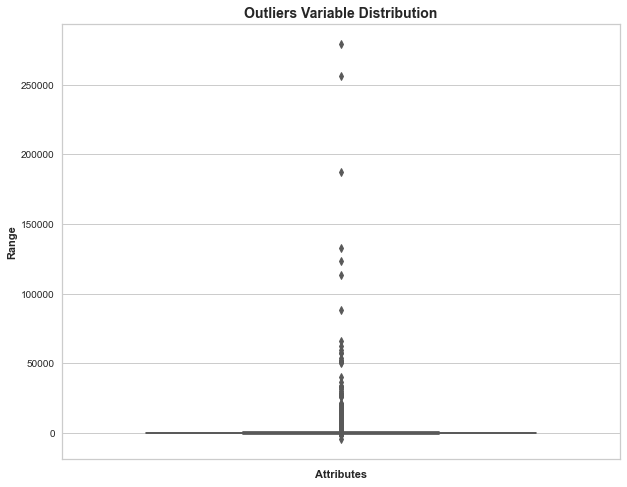

In [241]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(t_rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Dari output diatas, bisa diketahui bahwa terdapat outlier. Kita harus mengatasi outlier-outlier tersebut.

Untuk mengatasi outlier, kita gunakan cara statistik yaitu dengan menggunakan interquartile data (IQR)

In [243]:
# Mengatasi outlier untuk variabel Amount
Q1 = t_rfm.Amount.quantile(0.05)
Q3 = t_rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
t_rfm = t_rfm[(t_rfm.Amount >= Q1 - 1.5*IQR) & (t_rfm.Amount <= Q3 + 1.5*IQR)]

# Mengatasi outlier untuk variabel Recency
Q1 = t_rfm.Recency.quantile(0.05)
Q3 = t_rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
t_rfm = t_rfm[(t_rfm.Recency >= Q1 - 1.5*IQR) & (t_rfm.Recency <= Q3 + 1.5*IQR)]

# Mengatasi outlier untuk variabel Frequency
Q1 = t_rfm.Frequency.quantile(0.05)
Q3 = t_rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
t_rfm = t_rfm[(t_rfm.Frequency >= Q1 - 1.5*IQR) & (t_rfm.Frequency <= Q3 + 1.5*IQR)]

#### Rescalling

Scalling data sangat penting untuk dilakukan. Dengan scalling data, kita bisa mengubah skala jarak antara variabel agar menjadi lebih dekat dan akurat.

Saya akan menggunakan metode Standardization.

In [246]:
rfm_df = t_rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)

### Building K-Means Model

Kita menginisialisasikan data kita yang sudah di scalling ke model K-Means

In [247]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [248]:
kmeans.labels_

array([0, 1, 3, ..., 0, 3, 3])

Berdasarkan output diatas, kita bisa melihat indeks label dari K-Means. Karena kita inisialisasi cluster sebanyak 4, maka ada 4 indeks, yaitu 0, 1, 2, 3

Untuk menentukan apakah cluster yang telah diinisialisasikan sudah optimal, maka kita gunakan metode Silhouette Score

In [249]:
# Mencari koefisien silhouette score
from sklearn.metrics import silhouette_score

# Membuat visualisasi dari clusternya
from yellowbrick.cluster import SilhouetteVisualizer

In [250]:
# Kalkulasi skor silhouette
score = silhouette_score(rfm_df_scaled, kmeans.labels_, metric = 'euclidean')

print('Silhouette Score: %.3f' %score)

Silhouette Score: 0.482


Berdasarkan output, maka banyak cluster masih belum optimal, karena nilai skornya masih jauh dari +1

Untuk melihat silhouette score dari masing-masing n-clusters

In [251]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.477782010021685
For n_clusters=5, the silhouette score is 0.466103965297297
For n_clusters=6, the silhouette score is 0.41758431193450735
For n_clusters=7, the silhouette score is 0.41817955959931724
For n_clusters=8, the silhouette score is 0.40764335829376047


Dari output, kita bisa lihat bahwa n cluster = 2 dan 3 memiliki skor yang terbesar. Namun untuk clustering lebih baik sebanyak nomor ganjil, maka dari itu kita gunakan n cluster = 3

Kita inisialisasikan kembali data kita dengan n clusternya sebesar 3 ke model K-Means

In [252]:
kmeans_new = KMeans(n_clusters=3, max_iter=50)
kmeans_new.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [253]:
score = silhouette_score(rfm_df_scaled, kmeans_new.labels_, metric = 'euclidean')
print('Silhouette Score: %.3f' %score)

Silhouette Score: 0.508


Bisa dilihat di output bahwa silhouette score yang dihasilkan cukup baik

### Final Analysis

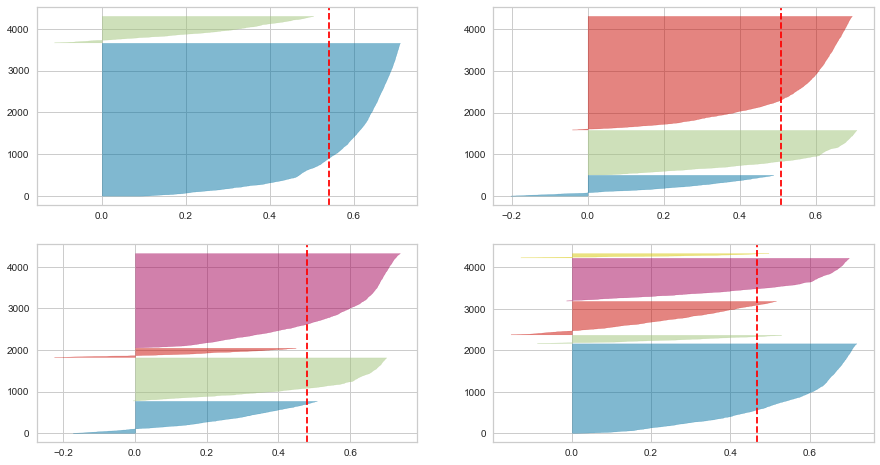

In [256]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2,3,4,5] :
    '''
    Buat instance KMeans untuk jumlah cluster yang berbeda
    '''
    kmeans_new = KMeans(n_clusters = i, init='k-means++', n_init=10, max_iter=100,
               random_state = 42)
    q,mod = divmod(i,2)
    '''
    Buat instance SilhouetteVisualize dengan instance KMeans
    Sesuaikan dengan Visualizer
    '''
    visual = SilhouetteVisualizer(kmeans_new, colors='yellowbrick', ax=ax[q-1][mod])
    visual.fit(rfm_df_scaled)

Dari grafik diatas, kita bisa analisis menjadi beberapa poin :
- Untuk n-cluster 4 dan 5 tidak optimal, karena :
     - Garis merahnya terletak dibawah 0.5, maka n-cluster 3 dan 4 tidak optimal.
     - Ukuran besar antara plot cluster terlihat sangat tidak serupa.

- Untuk n-cluster 2 dan 3 lebih optimal, karena :
Garis merahnya terletak lebih mendekati 0.6, maka lebih optimal dibandingkan n-cluster 4 dan 5

Jadi, jika kita akan memilih n-cluster mana yang lebih optimal, kita gunakan n-cluster = 3 karena ukuran besar antara plot cluster lebih serupa antara clusternya dibandingkan di n-cluster = 2.

Maka, n-cluster optimalnya adalah 3